# Ligthning Fast One-Shot Side Any Input State Optimization
## Notebook prepared to concatenate optimization calculations up to 5 algorythms
## Implicit guess decision - most likelyhood guess during optimization

## Imports

In [342]:
import numpy as np
import random
import itertools
import math
import time
import pickle
from typing import Optional, Tuple, cast, List, Dict
from bitarray.util import count_xor, urandom
from bitarray import frozenbitarray
from qiskit import Aer, QuantumCircuit, execute, QuantumRegister, ClassicalRegister
from qiskit.result.result import Result
from qiskit.aqua.components.optimizers import SLSQP, L_BFGS_B, CRS, DIRECT_L, DIRECT_L_RAND, ESCH, ISRES

## General auxiliary functions

In [343]:
# Variable declarations

# Optimization algorithms
A1 = 'DIRECT_L'
#A2 = 'DIRECT_L'
#A3 = 'DIRECT_L_RAND'
#A4 = 'ESCH'
#A5 = 'ISRES'

eta_splits = 20

iterations = 1000
shots = 100000

filename1 = '20210414b_C2_A1_100_10000'
#filename2 = '20210414a_C2_A2_500_10000'
#filename3 = '20210414a_C2_A3_500_10000'
#filename4 = '20210414a_C2_A4_500_10000'
#filename5 = '20210414a_C2_A5_500_10000'

In [344]:
""" save and load results to and from a file """
def save_results_to_disk(obj, name ):
    with open('results/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_results_from_file(name ):
    with open('results/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [345]:
def get_combinations_two_etas_without_repeats_from_etas(angles_etas: List[float]) -> List[Tuple[float, float]]:
    """ from a given list of attenuations factors create a
        list of all combinatorial pairs of possible etas
        without repeats
        For us it is the same testing first eta 0.1 and second eta 0.2
        than first eta 0.2 and second eta 0.1
        Though, we will always put the greater value as the first pair element
    """
    # when there is only one element, we add the same element
    if len(angles_etas) == 1:
        angles_etas.append(angles_etas[0])
    # get combinations of two etas without repeats
    eta_pairs = list(itertools.combinations(angles_etas, 2))

    return reorder_pairs(eta_pairs)

In [346]:
def reorder_pairs(pairs: List[Tuple[float, float]]) -> List[Tuple[float, float]]:
    """ reorder received pairs setting first the element of the tuple
        as greater or equal de second one
    """
    reordered_pairs = pairs
    for idx, pair in enumerate(pairs):
        reordered_pairs[idx] = reorder_pair(pair)
    return reordered_pairs

In [347]:
def reorder_pair(pair: Tuple[float, float]) -> Tuple[float, float]:
    if pair[0] < pair[1]:
        return (pair[1], pair[0])
    return pair

In [348]:
#GLOBAL_BACKEND=Aer.get_backend('qasm_simulator')
#GLOBAL_ETA_PAIR = (0,0)
#optimization_setup = { 'optimizer_algorithms': ['DIRECT_L'],
#                        'optimizer_iterations': [1000],
#                        'attenuation_angles': np.append(np.arange(0, np.pi/2, np.pi/2/20), np.pi/2),
#                        'initial_parameters': [0, 0, 0, 0, 0],
#                        'variable_bounds': [(0, 1),   # amplitude_probability
#                                            (0, 2*np.pi),  # rx1
#                                            (0, 2*np.pi),  # ry1
#                                            (0, 2*np.pi),  # rx0
#                                            (0, 2*np.pi)], # ry0
#                        'plays': 10000}
#GLOBAL_ETA_PAIRS = get_combinations_two_etas_without_repeats_from_etas(optimization_setup['attenuation_angles'])
#GLOBAL_PLAYS = optimization_setup['plays']

## Auxiliary functions for preparing the optimization (until the cost function)

In [349]:
def find_optimal_configurations(optimization_setup: dict, clone_setup: Optional[dict]=None) -> dict:
    """ Finds out the optimal configuration for each pair of attenuation levels
        using the configured optimization algorithm """
    eta_pairs_idx_to_optimize, optimal_configurations = _select_eta_pairs_to_optimize(clone_setup)

    print(f'number of eta_pairs_idx_to_optimize: {len(eta_pairs_idx_to_optimize)} -> {eta_pairs_idx_to_optimize}')

    program_start_time = time.time()
    print("Starting the execution")
    
    for eta_pair_idx in eta_pairs_idx_to_optimize:
        start_time = time.time()
        GLOBAL_ETA_PAIR = GLOBAL_ETA_PAIRS[eta_pair_idx]
        result = _compute_best_configuration(optimization_setup, GLOBAL_ETA_PAIR)
        optimal_configurations['probabilities'].append(result['best_probability'])
        optimal_configurations['configurations'].append(result['best_configuration'])
        optimal_configurations['best_algorithm'].append(result['best_algorithm'])
        optimal_configurations['number_calls_made'].append(result['number_calls_made'])
        end_time = time.time()
        print(f"Pair of etas # {eta_pair_idx} of {len(eta_pairs_idx_to_optimize)}, time taken this pair of etas: " +
              f'{np.round((end_time - start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - start_time) % 60, 0)} seconds')
        print("total minutes taken this pair of etas: ", int(np.round((end_time - start_time) / 60)))
        print("total time taken so far: " +
              f'{np.round((end_time - program_start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - program_start_time) % 60, 0)} seconds')
    end_time = time.time()
    print("total minutes of execution time: ", int(np.round((end_time - program_start_time) / 60)))
    print(f'Number eta pairs optimized: {len(eta_pairs_idx_to_optimize)}' +
          f'from the total eta pairs: {len(GLOBAL_ETA_PAIRS)} ')
    optimal_configurations['eta_pairs'] = GLOBAL_ETA_PAIRS

    return optimal_configurations

In [350]:
    def _select_eta_pairs_to_optimize(clone_setup: Optional[dict]) -> Tuple[List[int], dict]:
        """ from the given clone setup, select the eta pairs to be optimized,
            and set the non computed pairs configuration as default values   """

        eta_pair_idx_init, eta_pair_idx_end = _set_eta_pair_index_bounds(clone_setup)
        index_dict = _build_eta_pair_index_lists(eta_pair_idx_init, eta_pair_idx_end)
        default_optimal_configurations = _set_default_optimal_configurations(index_dict['eta_pair_idx_to_skip'])

        return (index_dict['eta_pair_idx_to_compute'],
                default_optimal_configurations)

In [351]:
def _set_default_optimal_configurations(eta_pair_idx_to_skip: List[int]) -> dict:
    """ Return the optimal configurations set to default values for the indexes to be skipped """
    elements_to_skip = len(eta_pair_idx_to_skip)

    configurations: List[dict] = []
    for eta_pair_idx in eta_pair_idx_to_skip:
        one_configuration = {#'state_probability': 0,
                             'angle_In_rx1': 0,
                             'angle_In_ry1': 0,
                             'angle_In_rx0': 0,
                             'angle_In_ry0': 0,
                             'angle_Out_rx1': 0,
                             'angle_Out_ry1': 0,
                             'angle_Out_rx0': 0,
                             'angle_Out_ry0': 0,
                             'eta_pair': GLOBAL_ETA_PAIRS[eta_pair_idx]}
        configurations.append(one_configuration)

    return {'eta_pairs': [],
            'best_algorithm': ['NA'] * elements_to_skip,
            'probabilities': [0] * elements_to_skip,
            'configurations': configurations,
            'number_calls_made': [0] * elements_to_skip}

In [352]:
def _set_eta_pair_index_bounds(clone_setup: Optional[dict]) -> Tuple[int, int]:
    """ set the first and last eta pair index from which to optimize the configuration """
    total_eta_pairs = len(GLOBAL_ETA_PAIRS)

    if clone_setup is None or clone_setup['total_clones'] <= 1:
        return (0, total_eta_pairs)

    eta_pair_idx_init = int(np.floor(clone_setup['id_clone'] * total_eta_pairs / clone_setup['total_clones']))
    eta_pair_idx_end = min(int((clone_setup['id_clone'] + 1) *
                               total_eta_pairs / clone_setup['total_clones']), total_eta_pairs)
    return (eta_pair_idx_init, eta_pair_idx_end)

def _build_eta_pair_index_lists(eta_pair_idx_init: int, eta_pair_idx_end: int) -> Dict:
    """ create two lists with the the eta pair index to be computed and the index to be skipped """
    first_part_to_skip = list(range(0, eta_pair_idx_init))
    last_part_to_skip = list(range(eta_pair_idx_end, len(GLOBAL_ETA_PAIRS)))

    return {
        'eta_pair_idx_to_compute': list(range(eta_pair_idx_init, eta_pair_idx_end)),
        'eta_pair_idx_to_skip': first_part_to_skip + last_part_to_skip
    }

In [353]:
def _compute_best_configuration(optimization_setup: dict, GLOBAL_ETA_PAIR) -> dict:
    """ Find out the best configuration with a global pair of etas (channels) trying out
        a list of specified optimization algorithm """
    optimizer_algorithms = optimization_setup['optimizer_algorithms']
    optimizer_iterations = optimization_setup['optimizer_iterations']
    best_probability = 0
    best_configuration = []
    best_optimizer_algorithm = ""
    number_calls_made = 0

    for optimizer_algorithm, max_evals in zip(optimizer_algorithms, optimizer_iterations):
        print("Analyzing Optimizer Algorithm: ", optimizer_algorithm)
        if optimizer_algorithm == 'SLSQP':
            optimizer = SLSQP(maxiter=max_evals)
        if optimizer_algorithm == 'L_BFGS_B':
            optimizer = L_BFGS_B(maxfun=max_evals, maxiter=max_evals)
        if optimizer_algorithm == 'CRS':
            optimizer = CRS(max_evals=max_evals)
        if optimizer_algorithm == 'DIRECT_L':
            optimizer = DIRECT_L(max_evals=max_evals)
        if optimizer_algorithm == 'DIRECT_L_RAND':
            optimizer = DIRECT_L_RAND(max_evals=max_evals)
        if optimizer_algorithm == 'ESCH':
            optimizer = ESCH(max_evals=max_evals)
        if optimizer_algorithm == 'ISRES':
            optimizer = ISRES(max_evals=max_evals)

        ret = optimizer.optimize(num_vars=len(optimization_setup['initial_parameters']),
                                 objective_function=_cost_function,
                                 variable_bounds=optimization_setup['variable_bounds'],
                                 initial_point=optimization_setup['initial_parameters'])
#        print('Parámetros')
#        print(ret[0])
        print("Best Average Probability:", -ret[1])
        if (-ret[1]) > best_probability:
            best_configuration = ret[0]
            best_probability = -ret[1]
            number_calls_made = ret[2]
            best_optimizer_algorithm = optimizer_algorithm

    # Print results
    print("Final Best Optimizer Algorithm: ", best_optimizer_algorithm)
    print("Final Best Average Probability:", best_probability)
    print("Number of cost function calls made:", number_calls_made)
    print("Parameters Found: "
          #state_probability = " + str(best_configuration[0]) +
          + u"\u03D5" + "In_rx1 = " + str(int(math.degrees(best_configuration[0]))) + u"\u00B0" +
          ", " + u"\u03D5" + "In_ry1 = " + str(int(math.degrees(best_configuration[1]))) + u"\u00B0" +
          ", " + u"\u03D5" + "In_rx0 = " + str(int(math.degrees(best_configuration[2]))) + u"\u00B0" +
          ", " + u"\u03D5" + "In_ry0 = " + str(int(math.degrees(best_configuration[3]))) + u"\u00B0" +
          ", " + u"\u03D5" + "Out_rx1 = " + str(int(math.degrees(best_configuration[4]))) + u"\u00B0" +
          ", " + u"\u03D5" + "Out_ry1 = " + str(int(math.degrees(best_configuration[5]))) + u"\u00B0" +
          ", " + u"\u03D5" + "Out_rx0 = " + str(int(math.degrees(best_configuration[6]))) + u"\u00B0" +
          ", " + u"\u03D5" + "Out_ry0 = " + str(int(math.degrees(best_configuration[7]))) + u"\u00B0" +
          ", " + u"\u03B7" + u"\u2080" + " = " + str(int(math.degrees(GLOBAL_ETA_PAIR[0]))) + u"\u00B0" +
          ", " + u"\u03B7" + u"\u2081" + " = " + str(int(math.degrees(GLOBAL_ETA_PAIR[1]))) + u"\u00B0")
    
    best_configuration_dict = {#'state_probability': best_configuration[0],
                               'angle_In_rx1': best_configuration[0],
                               'angle_In_ry1': best_configuration[1],
                               'angle_In_rx0': best_configuration[2],
                               'angle_In_ry0': best_configuration[3],
                               'angle_Out_rx1': best_configuration[4],
                               'angle_Out_ry1': best_configuration[5],
                               'angle_Out_rx0': best_configuration[6],
                               'angle_Out_ry0': best_configuration[7],
                               'eta_pair': GLOBAL_ETA_PAIR} 
    
    return {'best_algorithm': best_optimizer_algorithm,
            'best_probability': best_probability,
            'best_configuration': best_configuration_dict,
            'number_calls_made': number_calls_made} 

In [354]:
def _cost_function(params: List[float]) -> float:
    """ Computes the cost of running a specific configuration for the number of plays
        defined in the optimization setup.
        Cost is computed as 1 (perfect probability) - average success probability for
        all the plays with the given configuration
        Returns the Cost (error probability).
    """
    configuration = {
#        'state_probability': params[0],
        'angle_In_rx1': params[0],
        'angle_In_ry1': params[1],
        'angle_In_rx0': params[2],
        'angle_In_ry0': params[3],
        'angle_Out_rx1': params[4],
        'angle_Out_ry1': params[5],
        'angle_Out_rx0': params[6],
        'angle_Out_ry0': params[7],
        'eta_pair': GLOBAL_ETA_PAIR}

    return - compute_new_average_success_probability(configuration=configuration,
                                                       plays=GLOBAL_PLAYS)

## Auxiliary functions for fast compute the circuit and success average probability

In [355]:
def compute_new_average_success_probability(configuration: dict,
                                            plays: Optional[int] = 100,) -> float:
    """ Computes the average success probability of running a specific configuration
        for the number of plays defined in the configuration.
    """
    random_etas, eta_shots = _get_random_etas_and_eta_shots(plays)
    #guesses_eta = _run_all_circuits_and_return_guess(configuration, eta_shots)
    #return _check_guesses_and_return_average_success_probability(plays, random_etas, guesses_eta)
    return _run_all_circuits_and_return_cost(configuration, eta_shots)

In [356]:
def _get_random_etas_and_eta_shots(plays: int) -> Tuple[frozenbitarray, Tuple[int, int]]:
    """ create a random bit string with length the number of plays and calculate the
        number of shots for each eta based on the random string value (0 -> eta0, 1 -> eta1)
    """
    random_etas = frozenbitarray(urandom(plays))
    eta1_shots = random_etas.count()
    eta0_shots = plays - eta1_shots
    return (random_etas, (eta0_shots, eta1_shots))

In [357]:
def _check_guesses_and_return_average_success_probability(plays: int, 
                                                          random_etas: frozenbitarray, 
                                                          guesses_eta: Tuple[List[int],List[int]]) -> float:
    """ check the guessed etas with the initial random etas and compute the average with a xor bitwise operation """
    guesses = frozenbitarray([guesses_eta[random_eta].pop(0) for random_eta in random_etas])
    return 1 - (count_xor(random_etas, guesses) / plays)

In [358]:
def _run_all_circuits_and_return_cost(configuration: dict,
                                       eta_shots: Optional[Tuple[int, int]] = (1, 1)) -> Tuple[List[int],
                                                                                               List[int]]:
    """ Create a pair of Quantum Circuits, in its transpiled form, from a given configuration """
    if eta_shots is None:
        eta_shots = (1, 1)

    reordered_configuration = _reorder_configuration(configuration)
    eta_counts = [cast(Result, execute(_create_one_circuit(reordered_configuration, eta),
                                         backend=GLOBAL_BACKEND,
                                         shots=eta_shots[idx],
                                         memory=False).result()).get_counts()
                    for idx, eta in enumerate(reordered_configuration['eta_pair'])]
    
    counts_distribution=[0.0, 0.0, 0.0, 0.0]
    if '00' in eta_counts[0]: 
        counts_distribution[0]= eta_counts[0]['00']
    if '01' in eta_counts[0]: 
        counts_distribution[1]= eta_counts[0]['01']
    if '10' in eta_counts[0]: 
        counts_distribution[2]= eta_counts[0]['10']
    if '11' in eta_counts[0]: 
        counts_distribution[3]= eta_counts[0]['11']
    if '00' in eta_counts[1]: 
        counts_distribution[0]= max([counts_distribution[0], eta_counts[1]['00']])
    if '01' in eta_counts[1]: 
        counts_distribution[1]= max([counts_distribution[1], eta_counts[1]['01']])
    if '10' in eta_counts[1]: 
        counts_distribution[2]= max([counts_distribution[2], eta_counts[1]['10']])
    if '11' in eta_counts[1]: 
        counts_distribution[3]= max([counts_distribution[3], eta_counts[1]['11']])
#    print(counts_distribution)
#    print(configuration)

    cost= (counts_distribution[0] + counts_distribution[1] + counts_distribution[2] + counts_distribution[3])/GLOBAL_PLAYS
#    print(cost)
    return cost

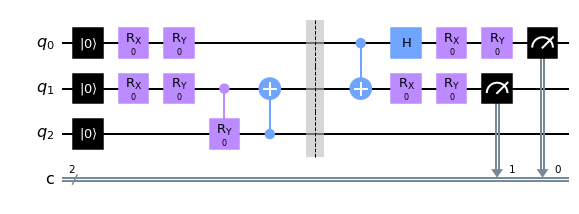

In [446]:
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)
#circuit.initialize([0,1,0,0], [0, 1])
circuit.reset(qreg_q)
circuit.rx(0, qreg_q[1])
circuit.ry(0, qreg_q[1])
circuit.rx(0, qreg_q[0])
circuit.ry(0, qreg_q[0])
circuit.cry(0, qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[2], qreg_q[1])
circuit.barrier()
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])
circuit.rx(0, qreg_q[1])
circuit.ry(0, qreg_q[1])
circuit.rx(0, qreg_q[0])
circuit.ry(0, qreg_q[0])
circuit.measure([0, 1], creg_c)
circuit.draw('mpl')

In [360]:
def _reorder_configuration(configuration: dict):
    return {#'state_probability': configuration['state_probability'],
            'angle_In_rx1': configuration['angle_In_rx1'],
            'angle_In_ry1': configuration['angle_In_ry1'],
            'angle_In_rx0': configuration['angle_In_rx0'],
            'angle_In_ry0': configuration['angle_In_ry0'],
            'angle_Out_rx1': configuration['angle_Out_rx1'],
            'angle_Out_ry1': configuration['angle_Out_ry1'],
            'angle_Out_rx0': configuration['angle_Out_rx0'],
            'angle_Out_ry0': configuration['angle_Out_ry0'],
            'eta_pair': reorder_pair(configuration['eta_pair'])
    }

In [361]:
def _create_one_circuit(configuration: dict,
                        eta: float) -> QuantumCircuit:
    """ Creates one circuit from a given configuration and eta """
    qreg_q = QuantumRegister(3, 'q')
    creg_c = ClassicalRegister(2, 'c')

#    initial_state = _prepare_initial_state_entangled(configuration['state_probability'])

    circuit = QuantumCircuit(qreg_q, creg_c)
#    circuit.initialize(initial_state, [0, 1])
    circuit.reset(qreg_q)
    circuit.rx(configuration['angle_In_rx1'], qreg_q[1])
    circuit.ry(configuration['angle_In_ry1'], qreg_q[1])
    circuit.rx(configuration['angle_In_rx0'], qreg_q[0])
    circuit.ry(configuration['angle_In_ry0'], qreg_q[0])
    circuit.cry(2 * eta, qreg_q[1], qreg_q[2])
    circuit.cx(qreg_q[2], qreg_q[1])
    circuit.barrier()
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.h(qreg_q[0])
    circuit.rx(configuration['angle_Out_rx1'], qreg_q[1])
    circuit.ry(configuration['angle_Out_ry1'], qreg_q[1])
    circuit.rx(configuration['angle_Out_rx0'], qreg_q[0])
    circuit.ry(configuration['angle_Out_ry0'], qreg_q[0])
    circuit.measure([0, 1], creg_c)
    return circuit

In [362]:
def _prepare_initial_state_entangled(state_probability: float) -> Tuple[complex, complex, complex, complex]:
    """ Prepare initial state: computing 'y' as the amplitudes  """
    # ORIGINAL
    return (0, np.sqrt(state_probability), np.sqrt(1 - state_probability), 0)
    # return (0, np.sqrt(1 - state_probability), np.sqrt(state_probability), 0)

In [363]:
def _get_counts_from_one_eta_counts(one_eta_counts: List[str]) -> List[int]:
    return [_guess_eta_from_counts(one_eta_count) for one_eta_count in one_eta_counts]

In [364]:
def _guess_eta_from_counts(counts: str) -> int:
    """ Decides which eta was used on the real execution from the 'counts' measured
        based on the guess strategy that is required to use
    """
    return _guess_eta_used_two_bit_strategy(counts)

In [365]:
def _guess_eta_used_two_bit_strategy(counts: str) -> int:
    """ Decides which eta was used on the real execution from the two 'counts' measured
        Qubits order MATTER!!!!
        "01" means that:
          the LEFTMOST bit (0) corresponds to the measurement of the qubit that goes THROUGH the channel
          and the RIGHTMOST bit (1) corresponds to the measurement of the qubit that goes OUTSIDE the channel
        Remember that we are only sending |01> + |10> entangles states
        Setting eta0 >= eta1:
            * outcome 00 -> eta0 as the most probable (more attenuation)
            * outcome 01 -> we do not know if there has been attenuation. 50% chance, random choice
            * outcome 10 -> eta1 as the most probable (less attenuation)
            * outcome 11 -> not possible, but in case we get it (from noisy simulation), 50% chance, random choice
    """
    if len(counts) != 2:
        raise ValueError('counts MUST be a two character length string')
    if counts == "00":
        return 0
    if counts == "10":
        return 1
    if counts == "01" or counts == "11":
        return random.choice([0, 1])
    raise ValueError("Accepted counts are '00', '01', '10', '11'")

## Launch Optimization

In [366]:
GLOBAL_BACKEND=Aer.get_backend('qasm_simulator')
GLOBAL_ETA_PAIR = (0,0)
optimization_setup = { 'optimizer_algorithms': [A1],
                        'optimizer_iterations': [iterations],
                        'attenuation_angles': np.append(np.arange(0, np.pi/2, np.pi/2/eta_splits), np.pi/2),
                        'initial_parameters': [0, 0, 0, 0, 0, 0, 0, 0],
                        'variable_bounds': [#(0, 1),   # amplitude_probability
                                            (0, 2*np.pi),  # In_rx1
                                            (0, 2*np.pi),  # In_ry1
                                            (0, 2*np.pi),  # In_rx0
                                            (0, 2*np.pi),  # In_ry0
                                            (0, 2*np.pi),  # Out_rx1
                                            (0, 2*np.pi),  # Out_ry1
                                            (0, 2*np.pi),  # Out_rx0
                                            (0, 2*np.pi)], # Out_ry0
                        'plays': shots}
GLOBAL_ETA_PAIRS = get_combinations_two_etas_without_repeats_from_etas(optimization_setup['attenuation_angles'])
GLOBAL_PLAYS = optimization_setup['plays']
clone_setup=None

eta_pairs_idx_to_optimize, optimal_configurations = _select_eta_pairs_to_optimize(clone_setup)

print(f'number of eta_pairs_idx_to_optimize: {len(eta_pairs_idx_to_optimize)} -> {eta_pairs_idx_to_optimize}')

program_start_time = time.time()
print("Starting the execution")
    
for eta_pair_idx in eta_pairs_idx_to_optimize:
    start_time = time.time()
    GLOBAL_ETA_PAIR = GLOBAL_ETA_PAIRS[eta_pair_idx]
    result = _compute_best_configuration(optimization_setup, GLOBAL_ETA_PAIR)
    # print(result)
    optimal_configurations['probabilities'].append(result['best_probability'])
    optimal_configurations['configurations'].append(result['best_configuration'])
    optimal_configurations['best_algorithm'].append(result['best_algorithm'])
    optimal_configurations['number_calls_made'].append(result['number_calls_made'])
    end_time = time.time()
    print(f"Pair of etas # {eta_pair_idx+1} of {len(eta_pairs_idx_to_optimize)}, time taken this pair of etas: " +
              f'{np.round((end_time - start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - start_time) % 60, 0)} seconds')
    print("total minutes taken this pair of etas: ", int(np.round((end_time - start_time) / 60)))
    print("total time taken so far: " +
              f'{np.round((end_time - program_start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - program_start_time) % 60, 0)} seconds')
end_time = time.time()
print("total minutes of execution time: ", int(np.round((end_time - program_start_time) / 60)))
print(f'Number eta pairs optimized: {len(eta_pairs_idx_to_optimize)}' +
          f'from the total eta pairs: {len(GLOBAL_ETA_PAIRS)} ')
optimal_configurations['eta_pairs'] = GLOBAL_ETA_PAIRS
results= optimal_configurations

number of eta_pairs_idx_to_optimize: 210 -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209]
Starting the ex

Best Average Probability: 0.92858
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.92858
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 2°, ϕIn_ry1 = 179°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 179°, ϕOut_rx0 = 72°, ϕOut_ry0 = 153°, η₀ = 67°, η₁ = 0°
Pair of etas # 15 of 210, time taken this pair of etas: 2.0 minutes and 2.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 31.0 minutes and 54.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.95391
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.95391
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 357°, ϕIn_ry1 = 180°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 177°, ϕOut_ry1 = 181°, ϕOut_rx0 = 168°, ϕOut_ry0 = 166°, η₀ = 72°, η₁ = 0°
Pair of etas # 16 of 210, time taken this pair of etas: 2.0 minutes and 2.0 seconds
total minutes taken this pair of etas:  2
total

Best Average Probability: 0.82724
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.82724
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 179°, ϕIn_ry1 = 2°, ϕIn_rx0 = 180°, ϕIn_ry0 = 178°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 128°, ϕOut_ry0 = 220°, η₀ = 54°, η₁ = 4°
Pair of etas # 31 of 210, time taken this pair of etas: 2.0 minutes and 2.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 64.0 minutes and 31.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.86277
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.86277
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 180°, ϕIn_ry1 = 2°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 178°, ϕOut_ry1 = 180°, ϕOut_rx0 = 184°, ϕOut_ry0 = 151°, η₀ = 58°, η₁ = 4°
Pair of etas # 32 of 210, time taken this pair of etas: 2.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  2
total 

Best Average Probability: 0.74068
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.74068
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 2°, ϕIn_ry1 = 184°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 339°, ϕOut_ry0 = 322°, η₀ = 45°, η₁ = 9°
Pair of etas # 47 of 210, time taken this pair of etas: 2.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 96.0 minutes and 8.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.77955
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.77955
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 6°, ϕIn_ry1 = 181°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 178°, ϕOut_rx0 = 61°, ϕOut_ry0 = 166°, η₀ = 49°, η₁ = 9°
Pair of etas # 48 of 210, time taken this pair of etas: 2.0 minutes and 2.0 seconds
total minutes taken this pair of etas:  2
total ti

Best Average Probability: 0.64957
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.64957
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 353°, ϕIn_ry1 = 180°, ϕIn_rx0 = 180°, ϕIn_ry0 = 175°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 140°, ϕOut_ry0 = 193°, η₀ = 36°, η₁ = 13°
Pair of etas # 62 of 210, time taken this pair of etas: 2.0 minutes and 3.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 127.0 minutes and 41.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.68665
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.68665
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 179°, ϕIn_ry1 = 353°, ϕIn_rx0 = 180°, ϕIn_ry0 = 175°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 33°, ϕOut_ry0 = 286°, η₀ = 40°, η₁ = 13°
Pair of etas # 63 of 210, time taken this pair of etas: 2.0 minutes and 2.0 seconds
total minutes taken this pair of etas:  2


Best Average Probability: 0.59324
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.59324
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 180°, ϕIn_ry1 = 357°, ϕIn_rx0 = 179°, ϕIn_ry0 = 184°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 46°, ϕOut_ry0 = 220°, η₀ = 31°, η₁ = 18°
Pair of etas # 77 of 210, time taken this pair of etas: 2.0 minutes and 3.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 157.0 minutes and 9.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.62872
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.62872
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 180°, ϕIn_ry1 = 6°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 166°, ϕOut_ry0 = 299°, η₀ = 36°, η₁ = 18°
Pair of etas # 78 of 210, time taken this pair of etas: 2.0 minutes and 3.0 seconds
total minutes taken this pair of etas:  2
tot

Best Average Probability: 0.568
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.568
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 353°, ϕIn_ry1 = 184°, ϕIn_rx0 = 175°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 237°, ϕOut_ry0 = 228°, η₀ = 31°, η₁ = 22°
Pair of etas # 92 of 210, time taken this pair of etas: 2.0 minutes and 2.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 188.0 minutes and 49.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.60322
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.60322
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 6°, ϕIn_ry1 = 180°, ϕIn_rx0 = 184°, ϕIn_ry0 = 181°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 60°, ϕOut_ry0 = 273°, η₀ = 36°, η₁ = 22°
Pair of etas # 93 of 210, time taken this pair of etas: 2.0 minutes and 2.0 seconds
total minutes taken this pair of etas:  2
total 

Best Average Probability: 0.57165
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.57165
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 180°, ϕIn_ry1 = 341°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 184°, ϕOut_ry1 = 180°, ϕOut_rx0 = 140°, ϕOut_ry0 = 179°, η₀ = 36°, η₁ = 27°
Pair of etas # 107 of 210, time taken this pair of etas: 2.0 minutes and 2.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 218.0 minutes and 25.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.61154
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.61154
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 353°, ϕIn_ry1 = 178°, ϕIn_rx0 = 180°, ϕIn_ry0 = 179°, ϕOut_rx1 = 184°, ϕOut_ry1 = 180°, ϕOut_rx0 = 140°, ϕOut_ry0 = 126°, η₀ = 40°, η₁ = 27°
Pair of etas # 108 of 210, time taken this pair of etas: 2.0 minutes and 4.0 seconds
total minutes taken this pair of etas: 

Best Average Probability: 0.61759
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.61759
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 180°, ϕIn_ry1 = 353°, ϕIn_rx0 = 175°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 233°, ϕOut_ry0 = 180°, η₀ = 45°, η₁ = 31°
Pair of etas # 122 of 210, time taken this pair of etas: 2.0 minutes and 3.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 249.0 minutes and 11.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.65579
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.65579
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 353°, ϕIn_ry1 = 175°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 184°, ϕOut_ry0 = 140°, η₀ = 49°, η₁ = 31°
Pair of etas # 123 of 210, time taken this pair of etas: 2.0 minutes and 3.0 seconds
total minutes taken this pair of etas: 

Best Average Probability: 0.69452
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.69452
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 180°, ϕIn_ry1 = 353°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 166°, ϕOut_ry0 = 193°, η₀ = 58°, η₁ = 36°
Pair of etas # 137 of 210, time taken this pair of etas: 2.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 280.0 minutes and 51.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.72704
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.72704
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 184°, ϕIn_ry1 = 6°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 175°, ϕOut_ry0 = 220°, η₀ = 63°, η₁ = 36°
Pair of etas # 138 of 210, time taken this pair of etas: 2.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  2

Best Average Probability: 0.7659
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.7659
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 180°, ϕIn_ry1 = 353°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 175°, ϕOut_rx0 = 193°, ϕOut_ry0 = 166°, η₀ = 76°, η₁ = 40°
Pair of etas # 152 of 210, time taken this pair of etas: 2.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 311.0 minutes and 39.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.78097
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.78097
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 357°, ϕIn_ry1 = 180°, ϕIn_rx0 = 180°, ϕIn_ry0 = 184°, ϕOut_rx1 = 357°, ϕOut_ry1 = 180°, ϕOut_rx0 = 51°, ϕOut_ry0 = 148°, η₀ = 81°, η₁ = 40°
Pair of etas # 153 of 210, time taken this pair of etas: 2.0 minutes and 1.0 seconds
total minutes taken this pair of etas:  2


Best Average Probability: 0.57758
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.57758
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 180°, ϕIn_ry1 = 11°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 179°, ϕOut_ry1 = 180°, ϕOut_rx0 = 46°, ϕOut_ry0 = 193°, η₀ = 58°, η₁ = 49°
Pair of etas # 167 of 210, time taken this pair of etas: 2.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 341.0 minutes and 19.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.61169
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.61169
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 180°, ϕIn_ry1 = 353°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 304°, ϕOut_ry0 = 126°, η₀ = 63°, η₁ = 49°
Pair of etas # 168 of 210, time taken this pair of etas: 2.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  2

Best Average Probability: 0.68459
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.68459
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 60°, ϕIn_ry1 = 166°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 48°, ϕOut_ry1 = 180°, ϕOut_rx0 = 299°, ϕOut_ry0 = 181°, η₀ = 90°, η₁ = 54°
Pair of etas # 182 of 210, time taken this pair of etas: 2.0 minutes and 4.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 372.0 minutes and 13.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.53749
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.53749
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 180°, ϕIn_ry1 = 20°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 180°, ϕOut_ry1 = 180°, ϕOut_rx0 = 20°, ϕOut_ry0 = 180°, η₀ = 63°, η₁ = 58°
Pair of etas # 183 of 210, time taken this pair of etas: 2.0 minutes and 3.0 seconds
total minutes taken this pair of etas:  2
t

Best Average Probability: 0.54932
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.54932
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 60°, ϕIn_ry1 = 180°, ϕIn_rx0 = 180°, ϕIn_ry0 = 180°, ϕOut_rx1 = 60°, ϕOut_ry1 = 180°, ϕOut_rx0 = 218°, ϕOut_ry0 = 299°, η₀ = 76°, η₁ = 67°
Pair of etas # 197 of 210, time taken this pair of etas: 2.0 minutes and 3.0 seconds
total minutes taken this pair of etas:  2
total time taken so far: 403.0 minutes and 54.0 seconds
Analyzing Optimizer Algorithm:  DIRECT_L
Best Average Probability: 0.57236
Final Best Optimizer Algorithm:  DIRECT_L
Final Best Average Probability: 0.57236
Number of cost function calls made: 1000
Parameters Found: ϕIn_rx1 = 193°, ϕIn_ry1 = 60°, ϕIn_rx0 = 180°, ϕIn_ry0 = 184°, ϕOut_rx1 = 179°, ϕOut_ry1 = 46°, ϕOut_rx0 = 180°, ϕOut_ry0 = 313°, η₀ = 81°, η₁ = 67°
Pair of etas # 198 of 210, time taken this pair of etas: 2.0 minutes and 5.0 seconds
total minutes taken this pair of etas:  2
t

In [367]:
save_results_to_disk(results, filename1)

In [368]:
GLOBAL_BACKEND=Aer.get_backend('qasm_simulator')
GLOBAL_ETA_PAIR = (0,0)
optimization_setup = { 'optimizer_algorithms': [A2],
                        'optimizer_iterations': [iterations],
                        'attenuation_angles': np.append(np.arange(0, np.pi/2, np.pi/2/eta_splits), np.pi/2),
                        'initial_parameters': [0, 0, 0, 0, 0],
                        'variable_bounds': [(0, 1),   # amplitude_probability
                                            (0, 2*np.pi),  # rx1
                                            (0, 2*np.pi),  # ry1
                                            (0, 2*np.pi),  # rx0
                                            (0, 2*np.pi)], # ry0
                        'plays': shots}
GLOBAL_ETA_PAIRS = get_combinations_two_etas_without_repeats_from_etas(optimization_setup['attenuation_angles'])
GLOBAL_PLAYS = optimization_setup['plays']
clone_setup=None

eta_pairs_idx_to_optimize, optimal_configurations = _select_eta_pairs_to_optimize(clone_setup)

print(f'number of eta_pairs_idx_to_optimize: {len(eta_pairs_idx_to_optimize)} -> {eta_pairs_idx_to_optimize}')

program_start_time = time.time()
print("Starting the execution")
    
for eta_pair_idx in eta_pairs_idx_to_optimize:
    start_time = time.time()
    GLOBAL_ETA_PAIR = GLOBAL_ETA_PAIRS[eta_pair_idx]
    result = _compute_best_configuration(optimization_setup, GLOBAL_ETA_PAIR)
    # print(result)
    optimal_configurations['probabilities'].append(result['best_probability'])
    optimal_configurations['configurations'].append(result['best_configuration'])
    optimal_configurations['best_algorithm'].append(result['best_algorithm'])
    optimal_configurations['number_calls_made'].append(result['number_calls_made'])
    end_time = time.time()
    print(f"Pair of etas # {eta_pair_idx+1} of {len(eta_pairs_idx_to_optimize)}, time taken this pair of etas: " +
              f'{np.round((end_time - start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - start_time) % 60, 0)} seconds')
    print("total minutes taken this pair of etas: ", int(np.round((end_time - start_time) / 60)))
    print("total time taken so far: " +
              f'{np.round((end_time - program_start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - program_start_time) % 60, 0)} seconds')
end_time = time.time()
print("total minutes of execution time: ", int(np.round((end_time - program_start_time) / 60)))
print(f'Number eta pairs optimized: {len(eta_pairs_idx_to_optimize)}' +
          f'from the total eta pairs: {len(GLOBAL_ETA_PAIRS)} ')
optimal_configurations['eta_pairs'] = GLOBAL_ETA_PAIRS
results= optimal_configurations

number of eta_pairs_idx_to_optimize: 210 -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209]
Starting the ex

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
save_results_to_disk(results, filename2)

In [ ]:
GLOBAL_BACKEND=Aer.get_backend('qasm_simulator')
GLOBAL_ETA_PAIR = (0,0)
optimization_setup = { 'optimizer_algorithms': [A3],
                        'optimizer_iterations': [iterations],
                        'attenuation_angles': np.append(np.arange(0, np.pi/2, np.pi/2/eta_splits), np.pi/2),
                        'initial_parameters': [0, 0, 0, 0, 0],
                        'variable_bounds': [(0, 1),   # amplitude_probability
                                            (0, 2*np.pi),  # rx1
                                            (0, 2*np.pi),  # ry1
                                            (0, 2*np.pi),  # rx0
                                            (0, 2*np.pi)], # ry0
                        'plays': shots}
GLOBAL_ETA_PAIRS = get_combinations_two_etas_without_repeats_from_etas(optimization_setup['attenuation_angles'])
GLOBAL_PLAYS = optimization_setup['plays']
clone_setup=None

eta_pairs_idx_to_optimize, optimal_configurations = _select_eta_pairs_to_optimize(clone_setup)

print(f'number of eta_pairs_idx_to_optimize: {len(eta_pairs_idx_to_optimize)} -> {eta_pairs_idx_to_optimize}')

program_start_time = time.time()
print("Starting the execution")
    
for eta_pair_idx in eta_pairs_idx_to_optimize:
    start_time = time.time()
    GLOBAL_ETA_PAIR = GLOBAL_ETA_PAIRS[eta_pair_idx]
    result = _compute_best_configuration(optimization_setup, GLOBAL_ETA_PAIR)
    # print(result)
    optimal_configurations['probabilities'].append(result['best_probability'])
    optimal_configurations['configurations'].append(result['best_configuration'])
    optimal_configurations['best_algorithm'].append(result['best_algorithm'])
    optimal_configurations['number_calls_made'].append(result['number_calls_made'])
    end_time = time.time()
    print(f"Pair of etas # {eta_pair_idx+1} of {len(eta_pairs_idx_to_optimize)}, time taken this pair of etas: " +
              f'{np.round((end_time - start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - start_time) % 60, 0)} seconds')
    print("total minutes taken this pair of etas: ", int(np.round((end_time - start_time) / 60)))
    print("total time taken so far: " +
              f'{np.round((end_time - program_start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - program_start_time) % 60, 0)} seconds')
end_time = time.time()
print("total minutes of execution time: ", int(np.round((end_time - program_start_time) / 60)))
print(f'Number eta pairs optimized: {len(eta_pairs_idx_to_optimize)}' +
          f'from the total eta pairs: {len(GLOBAL_ETA_PAIRS)} ')
optimal_configurations['eta_pairs'] = GLOBAL_ETA_PAIRS
results= optimal_configurations

In [ ]:
save_results_to_disk(results, filename3)

In [ ]:
GLOBAL_BACKEND=Aer.get_backend('qasm_simulator')
GLOBAL_ETA_PAIR = (0,0)
optimization_setup = { 'optimizer_algorithms': [A4],
                        'optimizer_iterations': [iterations],
                        'attenuation_angles': np.append(np.arange(0, np.pi/2, np.pi/2/eta_splits), np.pi/2),
                        'initial_parameters': [0, 0, 0, 0, 0],
                        'variable_bounds': [(0, 1),   # amplitude_probability
                                            (0, 2*np.pi),  # rx1
                                            (0, 2*np.pi),  # ry1
                                            (0, 2*np.pi),  # rx0
                                            (0, 2*np.pi)], # ry0
                        'plays': shots}
GLOBAL_ETA_PAIRS = get_combinations_two_etas_without_repeats_from_etas(optimization_setup['attenuation_angles'])
GLOBAL_PLAYS = optimization_setup['plays']
clone_setup=None

eta_pairs_idx_to_optimize, optimal_configurations = _select_eta_pairs_to_optimize(clone_setup)

print(f'number of eta_pairs_idx_to_optimize: {len(eta_pairs_idx_to_optimize)} -> {eta_pairs_idx_to_optimize}')

program_start_time = time.time()
print("Starting the execution")
    
for eta_pair_idx in eta_pairs_idx_to_optimize:
    start_time = time.time()
    GLOBAL_ETA_PAIR = GLOBAL_ETA_PAIRS[eta_pair_idx]
    result = _compute_best_configuration(optimization_setup, GLOBAL_ETA_PAIR)
    # print(result)
    optimal_configurations['probabilities'].append(result['best_probability'])
    optimal_configurations['configurations'].append(result['best_configuration'])
    optimal_configurations['best_algorithm'].append(result['best_algorithm'])
    optimal_configurations['number_calls_made'].append(result['number_calls_made'])
    end_time = time.time()
    print(f"Pair of etas # {eta_pair_idx+1} of {len(eta_pairs_idx_to_optimize)}, time taken this pair of etas: " +
              f'{np.round((end_time - start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - start_time) % 60, 0)} seconds')
    print("total minutes taken this pair of etas: ", int(np.round((end_time - start_time) / 60)))
    print("total time taken so far: " +
              f'{np.round((end_time - program_start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - program_start_time) % 60, 0)} seconds')
end_time = time.time()
print("total minutes of execution time: ", int(np.round((end_time - program_start_time) / 60)))
print(f'Number eta pairs optimized: {len(eta_pairs_idx_to_optimize)}' +
          f'from the total eta pairs: {len(GLOBAL_ETA_PAIRS)} ')
optimal_configurations['eta_pairs'] = GLOBAL_ETA_PAIRS
results= optimal_configurations

In [ ]:
save_results_to_disk(results, filename4)

In [ ]:
GLOBAL_BACKEND=Aer.get_backend('qasm_simulator')
GLOBAL_ETA_PAIR = (0,0)
optimization_setup = { 'optimizer_algorithms': [A5],
                        'optimizer_iterations': [iterations],
                        'attenuation_angles': np.append(np.arange(0, np.pi/2, np.pi/2/eta_splits), np.pi/2),
                        'initial_parameters': [0, 0, 0, 0, 0],
                        'variable_bounds': [(0, 1),   # amplitude_probability
                                            (0, 2*np.pi),  # rx1
                                            (0, 2*np.pi),  # ry1
                                            (0, 2*np.pi),  # rx0
                                            (0, 2*np.pi)], # ry0
                        'plays': shots}
GLOBAL_ETA_PAIRS = get_combinations_two_etas_without_repeats_from_etas(optimization_setup['attenuation_angles'])
GLOBAL_PLAYS = optimization_setup['plays']
clone_setup=None

eta_pairs_idx_to_optimize, optimal_configurations = _select_eta_pairs_to_optimize(clone_setup)

print(f'number of eta_pairs_idx_to_optimize: {len(eta_pairs_idx_to_optimize)} -> {eta_pairs_idx_to_optimize}')

program_start_time = time.time()
print("Starting the execution")
    
for eta_pair_idx in eta_pairs_idx_to_optimize:
    start_time = time.time()
    GLOBAL_ETA_PAIR = GLOBAL_ETA_PAIRS[eta_pair_idx]
    result = _compute_best_configuration(optimization_setup, GLOBAL_ETA_PAIR)
    # print(result)
    optimal_configurations['probabilities'].append(result['best_probability'])
    optimal_configurations['configurations'].append(result['best_configuration'])
    optimal_configurations['best_algorithm'].append(result['best_algorithm'])
    optimal_configurations['number_calls_made'].append(result['number_calls_made'])
    end_time = time.time()
    print(f"Pair of etas # {eta_pair_idx+1} of {len(eta_pairs_idx_to_optimize)}, time taken this pair of etas: " +
              f'{np.round((end_time - start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - start_time) % 60, 0)} seconds')
    print("total minutes taken this pair of etas: ", int(np.round((end_time - start_time) / 60)))
    print("total time taken so far: " +
              f'{np.round((end_time - program_start_time)/60, 0)} minutes' +
              f' and {np.round((end_time - program_start_time) % 60, 0)} seconds')
end_time = time.time()
print("total minutes of execution time: ", int(np.round((end_time - program_start_time) / 60)))
print(f'Number eta pairs optimized: {len(eta_pairs_idx_to_optimize)}' +
          f'from the total eta pairs: {len(GLOBAL_ETA_PAIRS)} ')
optimal_configurations['eta_pairs'] = GLOBAL_ETA_PAIRS
results= optimal_configurations

In [ ]:
save_results_to_disk(results, filename5)

In [ ]:
# results

In [ ]:
#qreg_q = QuantumRegister(3, 'q')
#creg_c = ClassicalRegister(2, 'c')
#circuit = QuantumCircuit(qreg_q, creg_c)
#circuit.initialize([0,1,0,0], [0, 1])
#circuit.reset(qreg_q[2])
#circuit.cry(0, qreg_q[1], qreg_q[2])
#circuit.cx(qreg_q[2], qreg_q[1])
#circuit.barrier()
#circuit.cx(qreg_q[0], qreg_q[1])
#circuit.h(qreg_q[0])
#circuit.rx(0, qreg_q[1])
#circuit.ry(0, qreg_q[1])
#circuit.rx(0, qreg_q[0])
#circuit.ry(0, qreg_q[0])
#circuit.measure([0, 1], creg_c)
#circuit.draw()

In [376]:
range(len(result1['eta_pairs']))

range(0, 210)

In [441]:
result1 = load_results_from_file(name='20210414b_C2_A1_1000_100000')
result2 = load_results_from_file(name='20210412c_C2_A1_1000_1000_TEST')

In [445]:
for i in range(len(result2['eta_pairs'])):
    result2['probabilities'][i]=result1['probabilities'][i]
save_results_to_disk(results2, '20210414b_C2_A1_1000_100000_')

NameError: name 'results2' is not defined

In [444]:
result2

{'eta_pairs': [(0.07853981633974483, 0.0),
  (0.15707963267948966, 0.0),
  (0.23561944901923448, 0.0),
  (0.3141592653589793, 0.0),
  (0.39269908169872414, 0.0),
  (0.47123889803846897, 0.0),
  (0.5497787143782138, 0.0),
  (0.6283185307179586, 0.0),
  (0.7068583470577035, 0.0),
  (0.7853981633974483, 0.0),
  (0.8639379797371931, 0.0),
  (0.9424777960769379, 0.0),
  (1.0210176124166828, 0.0),
  (1.0995574287564276, 0.0),
  (1.1780972450961724, 0.0),
  (1.2566370614359172, 0.0),
  (1.335176877775662, 0.0),
  (1.413716694115407, 0.0),
  (1.4922565104551517, 0.0),
  (1.5707963267948966, 0.0),
  (0.15707963267948966, 0.07853981633974483),
  (0.23561944901923448, 0.07853981633974483),
  (0.3141592653589793, 0.07853981633974483),
  (0.39269908169872414, 0.07853981633974483),
  (0.47123889803846897, 0.07853981633974483),
  (0.5497787143782138, 0.07853981633974483),
  (0.6283185307179586, 0.07853981633974483),
  (0.7068583470577035, 0.07853981633974483),
  (0.7853981633974483, 0.078539816339744

In [ ]:
save_results_to_disk(results, '20210414b_C2_A1_1000_100000_')